# Preâmbulo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import ks_2samp, spearmanr
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.linalg import toeplitz
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.style as style
sns.set()
sns.set_theme(style="darkgrid")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [3]:
# Parâmetros
dict_meses = {1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril", 5: "Maio",
              6: "Junho", 7: "Julho", 8: "Agosto", 9: "Setembro",
              10: "Outubro", 11: "Novembro", 12: "Dezembro"}

In [4]:
# Funções
def highlight_cells(val: float):
    '''Personalização do display dos dataframes de teste de hipóteses'''
    if val < 0.05:
        color = '#d14133'
    elif val == 1:
        color = '#636363'
    elif val > 0.05:
        color = '#399234'
    else:
        color = ''
    return 'background-color: {}'.format(color)


def matrix_spearman_test(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de correlação de Spearman 
    para as colunas selecionadas'''
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = spearmanr(df[i], df[j])
            data_frame[i][j] = p
    return data_frame


def matrix_ks_2samp_test_months(random_var: str, df: pd.DataFrame, meses: dict = dict_meses) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com o mês'''
    columns = [n for n in range(1, 13)]
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["date"].dt.month==i][random_var], 
                              df.loc[df["date"].dt.month==j][random_var])
            data_frame[i][j] = p
    data_frame = data_frame.rename(columns=meses, index=meses)
    return data_frame


def matrix_ks_2samp_test_types(random_var: str, df: pd.DataFrame, meses: dict = dict_meses) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com o tipo de ligação'''
    columns = [n for n in range(3)]
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["call_type"]==i][random_var], 
                              df.loc[df["call_type"]==j][random_var])
            data_frame[i][j] = p
    data_frame = data_frame.rename(columns={0: "Call_type 0", 1: "Call_type 1", 2: "Call_type 2"}, 
                       index={0: "Call_type 0", 1: "Call_type 1", 2: "Call_type 2"})
    return data_frame


def matrix_ks_2samp_test_weeks(random_var: str, df: pd.DataFrame, semanas: list) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com a semana do ano'''
    columns = semanas
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["date"].dt.isocalendar().week == i][random_var], 
                               df.loc[df["date"].dt.isocalendar().week == j][random_var])
            data_frame[i][j] = p
    return data_frame


def resumo_call_type(df, tipo):
    '''Apresenta um breve resumo do call type desejado, contendo número de chamadas atendidas,
    número de falhas e percentual de falhas'''
    df = df.loc[df["call_type"] == tipo]
    # Número de chamadas analisadas
    n = len(df)
    print(f"Ligações do tipo {tipo} atendidas em 2021:", n)

    # Chamadas que demoraram mais de um minuto para serem atendidas
    falhas = df.loc[df["wait_length"] > 60]
    qtd_falhas = len(falhas) 
    print("Ligações que demoraram mais de 60 segundos para atendimento:", qtd_falhas)

    # Percentual anual de falhas
    print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações do tipo {tipo} demoraram mais de 60 segundos para serem atendidas")

# Base de dados das ligações

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/calls.csv")
# Conversão do time stamp da data
df["date"] = pd.to_datetime(df.date, format="%d/%m/%Y")
df["call_started"] = pd.to_datetime(df.call_started, format="%I:%M:%S %p")
df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type
0,1,2021-01-01,1,1900-01-01 08:00:00,8:00:00 AM,8:14:22 AM,0,863,True,1
1,2,2021-01-01,2,1900-01-01 08:02:42,8:02:42 AM,8:07:31 AM,0,289,True,0
2,3,2021-01-01,3,1900-01-01 08:08:24,8:08:24 AM,8:10:13 AM,0,108,True,1
3,4,2021-01-01,4,1900-01-01 08:09:37,8:09:37 AM,8:13:45 AM,0,247,True,1
4,5,2021-01-01,5,1900-01-01 08:11:10,8:11:10 AM,8:15:28 AM,0,258,True,1


O gerente deseja que 90% das chamadas sejam atendidas em até um minuto, as unidades de tempo da base de dados estão em segundos

## Análise anual

In [6]:
# Número de chamadas analisadas
n = len(df)  # 51708

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = df.loc[df["meets_standard"] == False]
qtd_falhas = len(falhas)  # 4227

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações demoraram mais de 60 segundos para serem atendidas")

No ano de 2021, em média, 8.17% das ligações demoraram mais de 60 segundos para serem atendidas


### Distribuição de ligações por dia do ano

In [7]:
# Quantidade de dias comerciais registrados
len(df["date"].unique())

261

In [8]:
# Agrupando ligações por dia do ano
ligacoes = pd.DataFrame(df.groupby(["date"])["daily_caller"].max())
# Coloca a data como coluna
ligacoes = ligacoes.reset_index()
# Coluna meses para separação
ligacoes['mes'] = ligacoes['date'].dt.month

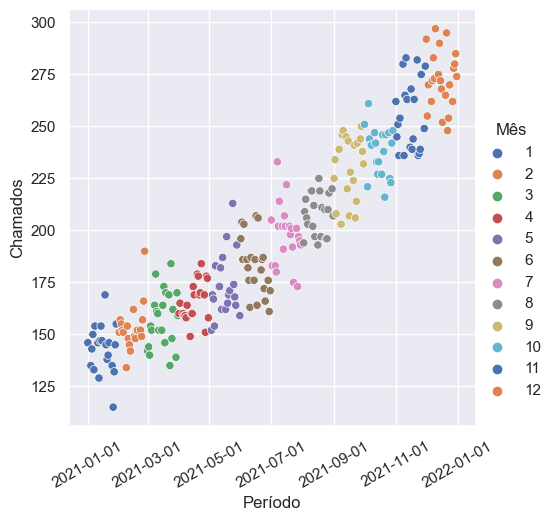

In [9]:
# Scatter plots separados por mês
fig = sns.relplot(data=ligacoes, x='date', y='daily_caller', hue="mes", palette="deep")
# Set the labels for the x-axis and y-axis
fig.set_axis_labels('Período', 'Chamados')
fig.set_xticklabels(rotation=30)
# Ajustes da legenda
sns.move_legend(fig, "center right")
fig.legend.set_title("Mês")
# Show the plot
plt.show()

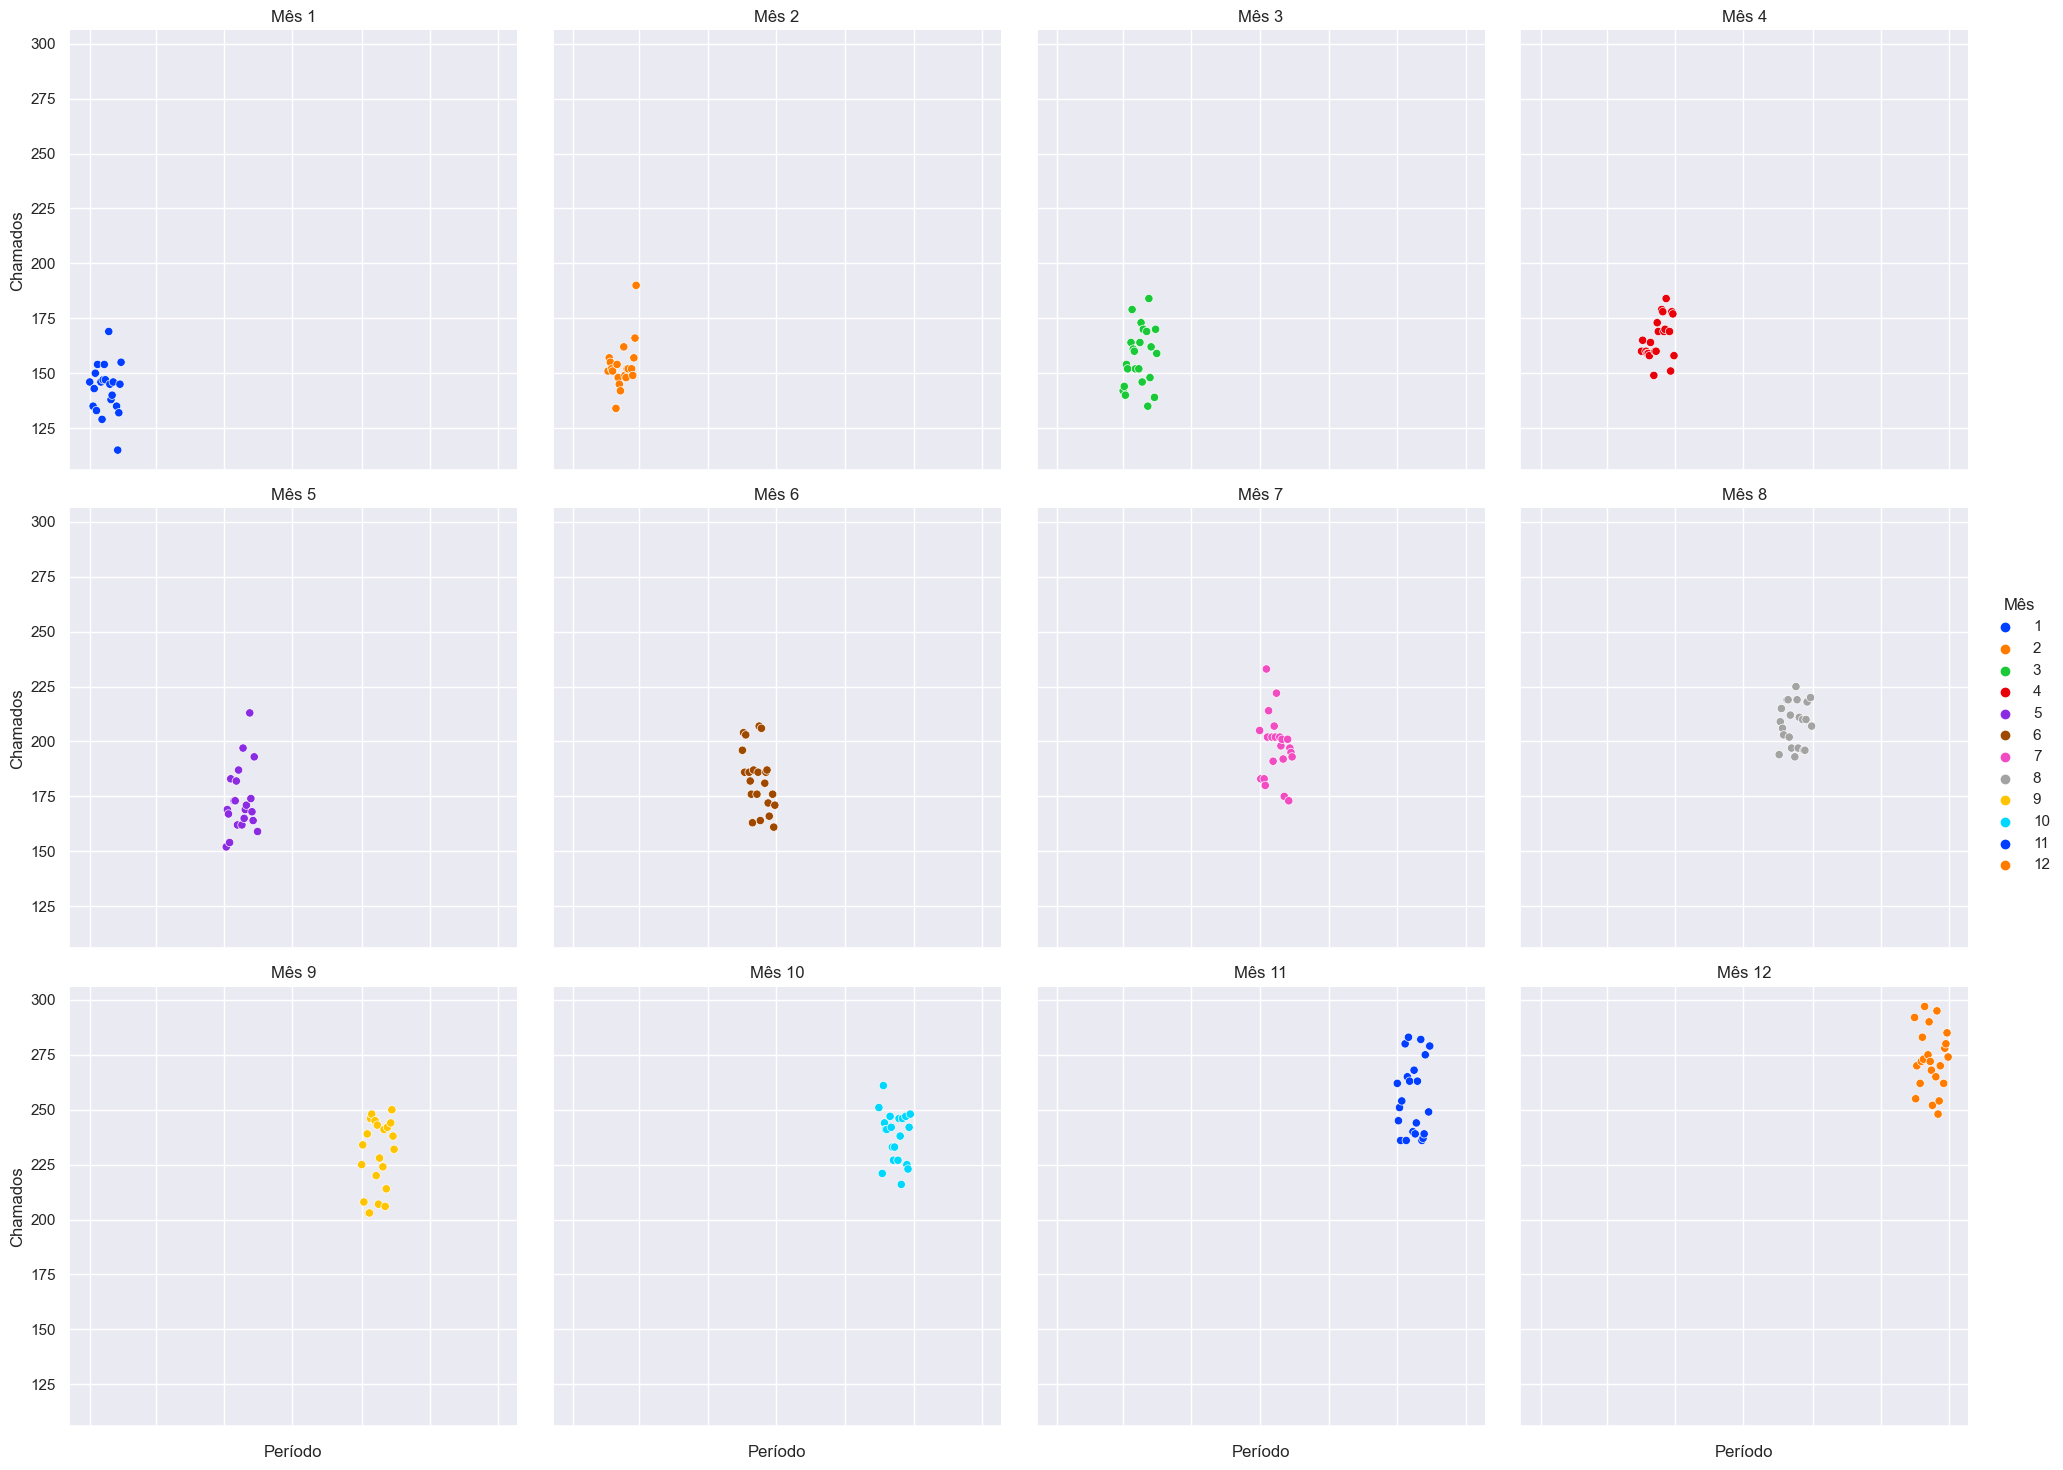

In [10]:
# Scatter plots separados por mês
fig = sns.relplot(data=ligacoes, x='date', y='daily_caller', hue="mes", palette="bright", col="mes", col_wrap=4)
# Set the labels for the x-axis and y-axis
fig.set_axis_labels('Período', 'Chamados')
fig.set_xticklabels(rotation=45)
fig.set_titles("Mês {col_name}")
fig.legend.set_title("Mês")
# Show the plot
plt.show()

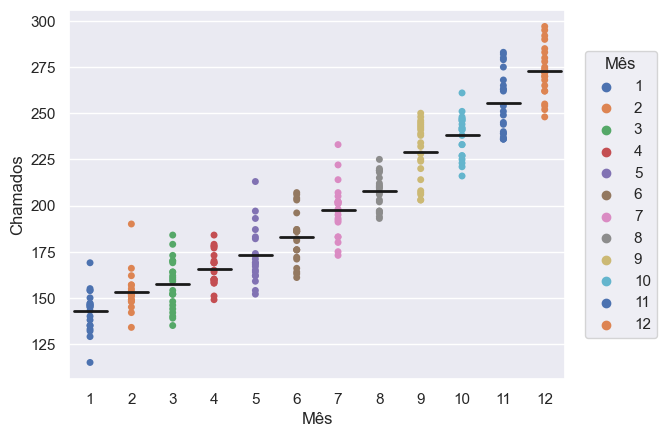

In [11]:
# Strip plot das ligações
fig = sns.stripplot(x="mes", y="daily_caller", hue="mes", data=ligacoes, jitter=False, palette="deep")
# Legenda
plt.legend(title="Mês")
sns.move_legend(fig, "center right", bbox_to_anchor=(1.2, 0.5))
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="mes",
            y="daily_caller",
            data=ligacoes,
            showfliers=False,
            showbox=False,
            showcaps=False, palette="deep")
# Plot
fig.set(xlabel="Mês", ylabel="Chamados");

Há uma tendência de crescimento do número de ligações recebidas por dia ao longo do ano

### Análise e descrição dos tempos de serviço e de espera

In [12]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",df["wait_length"].describe().to_string(),
      "\n","-"*100)
# Tempo de serviço
print("\nDescrição do Tempo de Serviço: \n",df["service_length"].describe().to_string(),
      "\n","-"*100)

Descrição do Tempo de Espera: 
 count    51708.000
mean        17.035
std         64.061
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        983.000 
 ----------------------------------------------------------------------------------------------------

Descrição do Tempo de Serviço: 
 count    51708.000
mean       299.103
std        299.866
min          0.000
25%         86.000
50%        208.000
75%        414.000
max       3110.000 
 ----------------------------------------------------------------------------------------------------


#### Boxplot tempo de espera

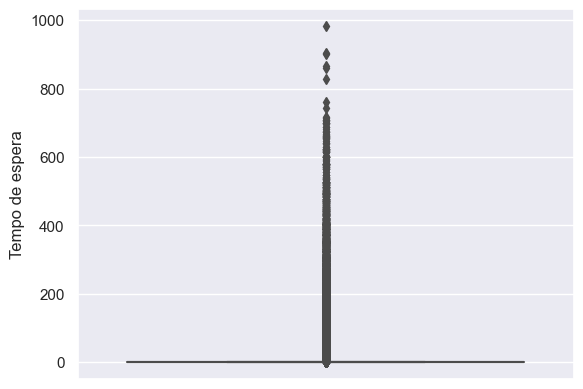

In [13]:
sns.boxplot(y="wait_length", data=df).set(ylabel="Tempo de espera");

Há muitos outliers pois mais de 75% dos valores de tempo de espera são nulos, é melhor, portanto, não retirá-los

In [14]:
print(get_common_distributions())

['cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform']


#### Boxplot tempo de serviço

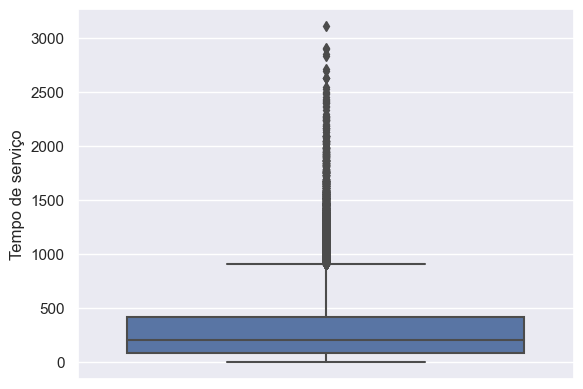

In [15]:
# Boxplot tempo de serviço
sns.boxplot(y="service_length", data=df).set(ylabel="Tempo de serviço");

Há também alguns outliers na análise do tempo de serviço que não julgamos necessário retirar, pois é interessante modelar essa variável aleatória com uma distribuição que leve em consideração a presença de valores extremos

In [16]:
# Comportamento do tempo médio de serviço ao longo do ano
t_servico = df.groupby(["date"])["service_length"].mean()
# Coloca a data como coluna
t_servico = t_servico.reset_index()
# Coluna meses para separação
t_servico['mes'] = t_servico['date'].dt.month
t_servico.head()

,date,service_length,mes
0,2021-01-01,303.158,1
1,2021-01-04,305.326,1
2,2021-01-05,254.049,1
3,2021-01-06,250.533,1
4,2021-01-07,343.090,1


#### Scatter plots separados por mês

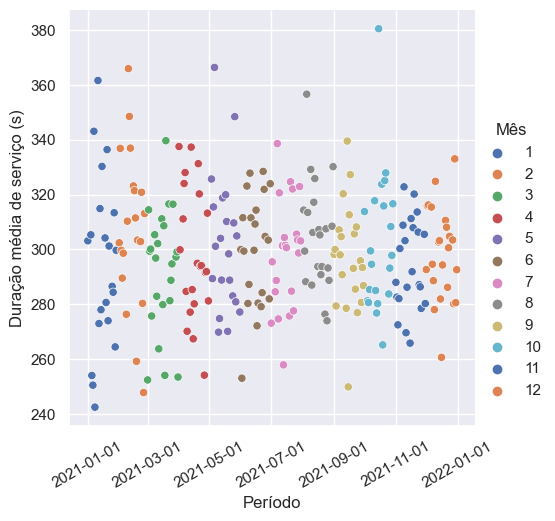

In [17]:
# Scatter plots separados por mês
fig = sns.relplot(data=t_servico, x='date', y='service_length', hue="mes", palette="deep")
# Set the labels for the x-axis and y-axis
fig.set_axis_labels('Período', 'Duração média de serviço (s)')
fig.set_xticklabels(rotation=30)
# Ajustes da legenda
sns.move_legend(fig, "center right")
fig.legend.set_title("Mês")
# Show the plot
plt.show()

#### Strip plot das ligações

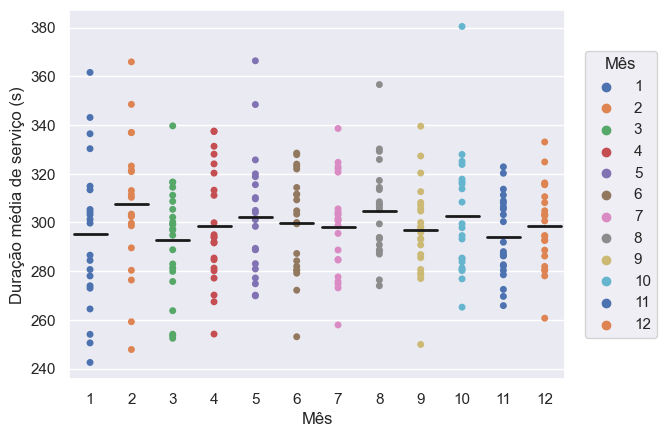

In [18]:
# Strip plot das ligações
fig = sns.stripplot(x="mes", y="service_length", hue="mes", data=t_servico, jitter=False, palette="deep")
# Legenda
plt.legend(title="Mês")
sns.move_legend(fig, "center right", bbox_to_anchor=(1.2, 0.5))
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="mes",
            y="service_length",
            data=t_servico,
            showfliers=False,
            showbox=False,
            showcaps=False, palette="deep")
# Plot
fig.set(xlabel="Mês", ylabel="Duração média de serviço (s)");

O tempo de serviço é aparentemente constante ao longo do ano, variando entre 4 e 6 minutos por ligação

Para testar nossas hipóteses utilizaremos o teste de Kolmogorov-Smirnov com 2 amostras. Esse teste é não paramétrico, isto é, não depende da distribuição das variáveis analisadas e testa a hipótese de que as duas amostras seguem uma mesma distribuição da seguinte forma:

$H_0:$ Ambas as amostras seguem uma mesma distribuição de probabilidade

$H_a:$ As amostras não seguem uma mesma distribuição de probabilidade

Portanto, definimos um nível de significância $\alpha = 0,05$ e analisamos os valores $p$ obtidos

In [19]:
testes = matrix_ks_2samp_test_months(random_var="service_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempo de serviço entre meses")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.539682,0.812293,0.256586,0.686531,0.213343,0.901055,0.501365,0.646593,0.455533,0.851607,0.244136
Fevereiro,0.539682,1.000000,0.166747,0.567613,0.521534,0.597656,0.501749,0.712118,0.626175,0.414783,0.134640,0.781156
Março,0.812293,0.166747,1.000000,0.556098,0.532970,0.227363,0.807715,0.514176,0.637592,0.571722,0.999157,0.438829
Abril,0.256586,0.567613,0.556098,1.000000,0.285730,0.607213,0.124089,0.972075,0.619759,0.352190,0.585494,0.898245
Maio,0.686531,0.521534,0.532970,0.285730,1.000000,0.964981,0.942911,0.610175,0.645276,0.899609,0.474400,0.518063
Junho,0.213343,0.597656,0.227363,0.607213,0.964981,1.000000,0.609780,0.862771,0.907490,0.578312,0.256022,0.947341
Julho,0.901055,0.501749,0.807715,0.124089,0.942911,0.609780,1.000000,0.515389,0.954315,0.660659,0.748578,0.587768
Agosto,0.501365,0.712118,0.514176,0.972075,0.610175,0.862771,0.515389,1.000000,0.849642,0.875283,0.379730,0.900799
Setembro,0.646593,0.626175,0.637592,0.619759,0.645276,0.907490,0.954315,0.849642,1.000000,0.735153,0.539403,0.691972
Outubro,0.455533,0.414783,0.571722,0.352190,0.899609,0.578312,0.660659,0.875283,0.735153,1.000000,0.456450,0.889161


O teste não paramétrico de Kolmogorov-Smirnov confirma que não há diferenças estatísticas significativas ($\alpha=0,05$) entre tempos de serviço ao longo do ano, avaliando em base mensal 

In [20]:
# Comportamento do tempo médio de espera ao longo do ano
t_espera = df.groupby(["date"])["wait_length"].mean()
# Coloca a data como coluna
t_espera = t_espera.reset_index()
# Coluna meses para separação
t_espera['mes'] = t_espera['date'].dt.month

#### Scatter plots tempos de espera separados por mês

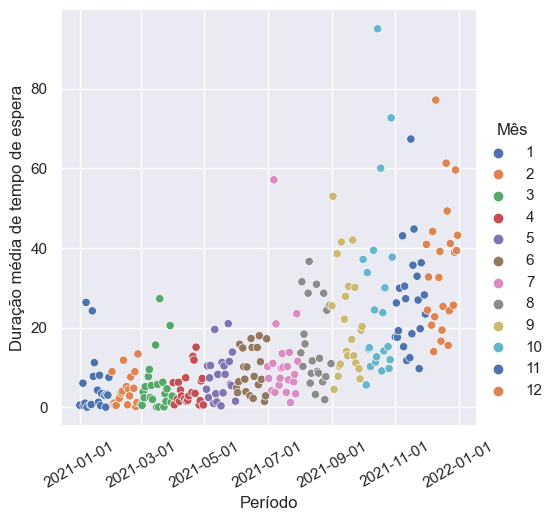

In [21]:
# Scatter plots separados por mês
fig = sns.relplot(data=t_espera, x='date', y='wait_length', hue="mes", palette="deep")
# Set the labels for the x-axis and y-axis
fig.set_axis_labels('Período', 'Duração média de tempo de espera')
fig.set_xticklabels(rotation=30)
# Ajustes da legenda
sns.move_legend(fig, "center right")
fig.legend.set_title("Mês")
# Show the plot
plt.show()

In [22]:
testes = matrix_ks_2samp_test_months(random_var="wait_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempo de espera entre meses")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.999994,0.987253,0.874800,0.068770,0.006124,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000
Fevereiro,0.999994,1.000000,1.000000,0.999986,0.251817,0.039507,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000
Março,0.987253,1.000000,1.000000,1.000000,0.336895,0.064457,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000
Abril,0.874800,0.999986,1.000000,1.000000,0.569863,0.134464,0.000120,0.000000,0.000000,0.000000,0.000000,0.000000
Maio,0.068770,0.251817,0.336895,0.569863,1.000000,0.997352,0.034338,0.000006,0.000000,0.000000,0.000000,0.000000
Junho,0.006124,0.039507,0.064457,0.134464,0.997352,1.000000,0.204852,0.000097,0.000000,0.000000,0.000000,0.000000
Julho,0.000001,0.000020,0.000031,0.000120,0.034338,0.204852,1.000000,0.117362,0.000018,0.000000,0.000000,0.000000
Agosto,0.000000,0.000000,0.000000,0.000000,0.000006,0.000097,0.117362,1.000000,0.079798,0.000014,0.000000,0.000000
Setembro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000018,0.079798,1.000000,0.072091,0.000001,0.000000
Outubro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.072091,1.000000,0.031059,0.000000


O teste mostra que os tempos de espera até abril seguem uma mesma distribuição, mas a partir de maio, vemos que o p-value de 0.069 já indica maiores diferenças entre os tempos de espera dos meses de janeiro e maio

### Fit dos tempos de serviço

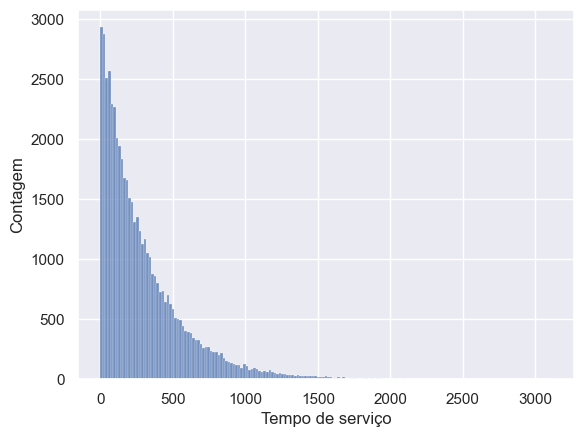

In [23]:
# Histograma dos tempos de serviço
sns.histplot(data=df, x="service_length").set(xlabel="Tempo de serviço", ylabel="Contagem");

O histograma com os valores de tempos de serviço apresenta comportamento similar ao de uma distribuição exponencial

A distribuição exponencial é a candidata mais adequada para modelar o tempo de serviço

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.29it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,3.229e-08,2183.934,-1.453e+06,inf,0.003,0.773


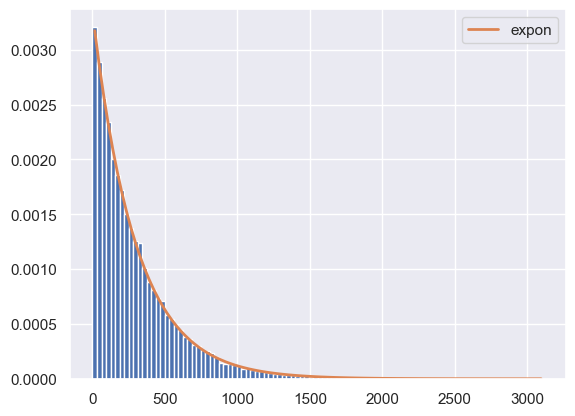

In [24]:
tempos_servico = df["service_length"].values
f = Fitter(tempos_servico, distributions="expon")
f.fit()
f.summary()

In [25]:
# Melhor fit para tempos de serviço é exponencial
f.get_best(method = 'sumsquare_error')

{'expon': {'loc': 0.0, 'scale': 299.1025953430804}}

O tempo de serviço pode ser modelado por uma exponencial de média $299.10$

### Análise dos tempos entre chegadas das ligações

Avaliaremos o tempo de chegada a partir da diferença entre a chegada das chamadas em um dia

In [26]:
df["arrival_time_diff"] = df["call_started"].diff().dt.total_seconds()
# Substitui os valores inadequados por 0
df.loc[df["arrival_time_diff"] < 0, "arrival_time_diff"] = 0
df = df.fillna(0)
df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type,arrival_time_diff
0,1,2021-01-01,1,1900-01-01 08:00:00,8:00:00 AM,8:14:22 AM,0,863,True,1,0.0
1,2,2021-01-01,2,1900-01-01 08:02:42,8:02:42 AM,8:07:31 AM,0,289,True,0,162.0
2,3,2021-01-01,3,1900-01-01 08:08:24,8:08:24 AM,8:10:13 AM,0,108,True,1,342.0
3,4,2021-01-01,4,1900-01-01 08:09:37,8:09:37 AM,8:13:45 AM,0,247,True,1,73.0
4,5,2021-01-01,5,1900-01-01 08:11:10,8:11:10 AM,8:15:28 AM,0,258,True,1,93.0


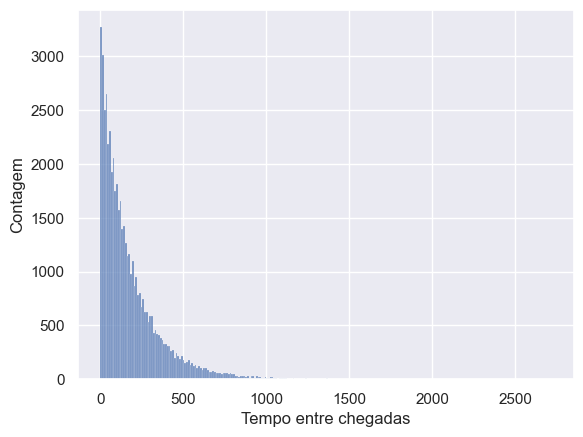

In [27]:
# Histograma dos intervalos de chegada
sns.histplot(data=df, x="arrival_time_diff").set(xlabel="Tempo entre chegadas", ylabel="Contagem");

In [28]:
# Agrupando time_diff por dia e obtendo a média
chegadas = df.groupby(["date"])["arrival_time_diff"].mean()
# Coloca a data como coluna
chegadas = chegadas.reset_index()
# Coluna meses para separação
chegadas['mes'] = chegadas['date'].dt.month

#### Scatter plots tempos entre chegadas separados por mês

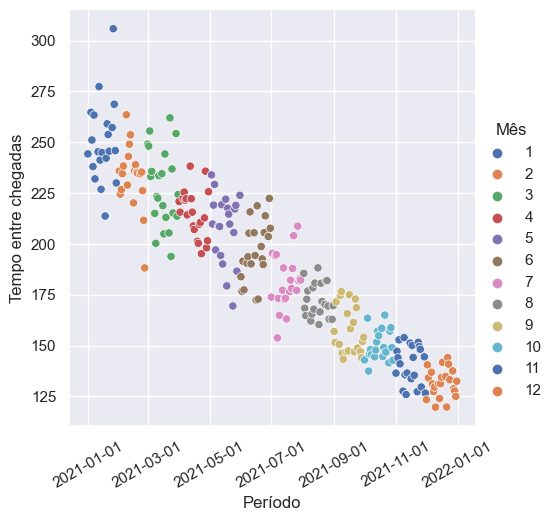

In [29]:
# Scatter plots separados por mês
fig = sns.relplot(data=chegadas, x='date', y='arrival_time_diff', hue="mes", palette="deep")
# Set the labels for the x-axis and y-axis
fig.set_axis_labels('Período', 'Tempo entre chegadas')
fig.set_xticklabels(rotation=30)
# Ajustes da legenda
sns.move_legend(fig, "center right")
fig.legend.set_title("Mês")
# Show the plot
plt.show()

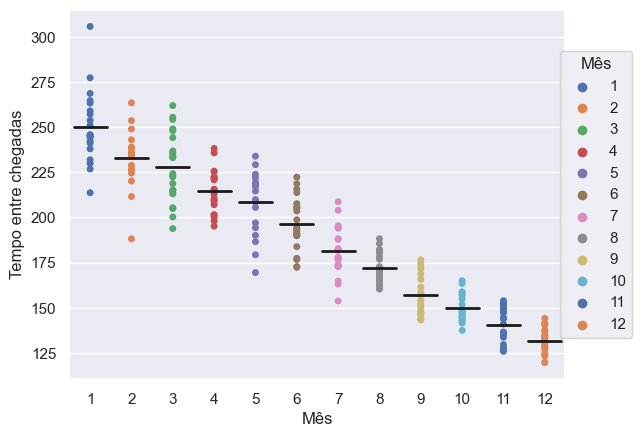

In [30]:
# Strip plot das ligações
fig = sns.stripplot(x="mes", y="arrival_time_diff", hue="mes", data=chegadas, jitter=False, palette="deep")
# Legenda
plt.legend(title="Mês")
sns.move_legend(fig, "center right", bbox_to_anchor=(1.15, 0.5))
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="mes",
            y="arrival_time_diff",
            data=chegadas,
            showfliers=False,
            showbox=False,
            showcaps=False, palette="deep")
# Plot
fig.set(xlabel="Mês", ylabel="Tempo entre chegadas");

Há uma tendência de queda do tempo médio entre as chegadas ao longo do ano, isso está de acordo com a constatação de que o número de chamadas recebidas aumenta ao longo do ano

In [31]:
testes = matrix_ks_2samp_test_months(random_var="arrival_time_diff", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para intervalo de chegadas em base mensal")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.044309,0.001751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fevereiro,0.044309,1.000000,0.050702,0.016655,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Março,0.001751,0.050702,1.000000,0.143584,0.005403,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Abril,0.000000,0.016655,0.143584,1.000000,0.063691,0.002019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Maio,0.000000,0.000006,0.005403,0.063691,1.000000,0.031724,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000
Junho,0.000000,0.000000,0.000011,0.002019,0.031724,1.000000,0.003164,0.000012,0.000000,0.000000,0.000000,0.000000
Julho,0.000000,0.000000,0.000000,0.000000,0.000034,0.003164,1.000000,0.238733,0.000005,0.000000,0.000000,0.000000
Agosto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.238733,1.000000,0.004325,0.000000,0.000000,0.000000
Setembro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.004325,1.000000,0.016511,0.000001,0.000000
Outubro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016511,1.000000,0.011048,0.000011


É interessante notar que mesmo para meses subsequentes, o teste de Kolgomogorov-Smirnov rejeita a hipótese de que a distribuição dos tempos de chegada entre eles seja idêntica. Isso indica que não é viável agregar períodos maiores que um mês para modelagem das chegadas. Os valores em vermelho são aqueles nos quais o teste rejeitou a hipótese nula, e, portanto, há diferenças significativas de distribuições de probabilidade entre os meses

In [32]:
print(df["arrival_time_diff"].describe().to_string())

count    51708.000
mean       179.668
std        188.007
min          0.000
25%         49.000
50%        121.000
75%        246.000
max       2718.000


Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,1.819e-07,2555.015,-1.364e+06,inf,0.013,3.530e-08


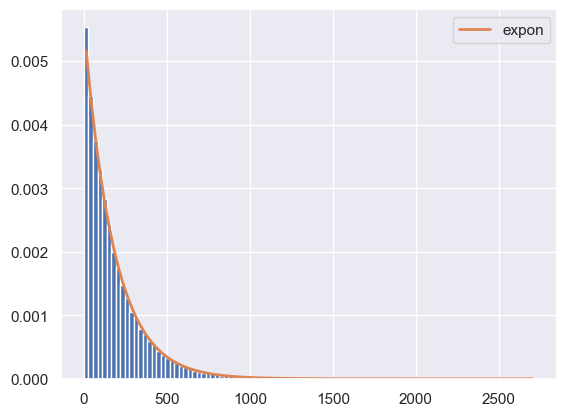

In [33]:
arrival_times = df["arrival_time_diff"].values
f = Fitter(arrival_times, distributions="expon")
f.fit()
f.summary()

In [34]:
# Fit exponencial para tempos entre chegadas
f.fitted_param['expon']

(0.0, 179.66765297439468)

O fit para o ano todo não modela tão bem o problema, visto que os tempos de chegada das chamadas variam ao longo do ano, e tais distribuições avaliadas não levam em conta o parâmetro do tempo

### Teste de correlação entre os tempos estudados utilizando a correlação de Spearman

In [35]:
df[["wait_length", "service_length", "arrival_time_diff"]].corr(method="spearman")

,wait_length,service_length,arrival_time_diff
wait_length,1.000,3.741e-03,-2.622e-01
service_length,0.004,1.000e+00,-5.214e-04
arrival_time_diff,-0.262,-5.214e-04,1.000e+00


In [36]:
testes = matrix_spearman_test(columns=["wait_length", "service_length", "arrival_time_diff"], df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de correlação de Spearman para as variáveis aleatórias estudadas")

,wait_length,service_length,arrival_time_diff
wait_length,0.000000,0.394934,0.000000
service_length,0.394934,0.000000,0.905620
arrival_time_diff,0.000000,0.905620,0.000000


Portanto, temos correlação entre wait_length e arrival_time_diff, confirmando a hipótese que o tempo de espera depende do intervalo entre chegadas

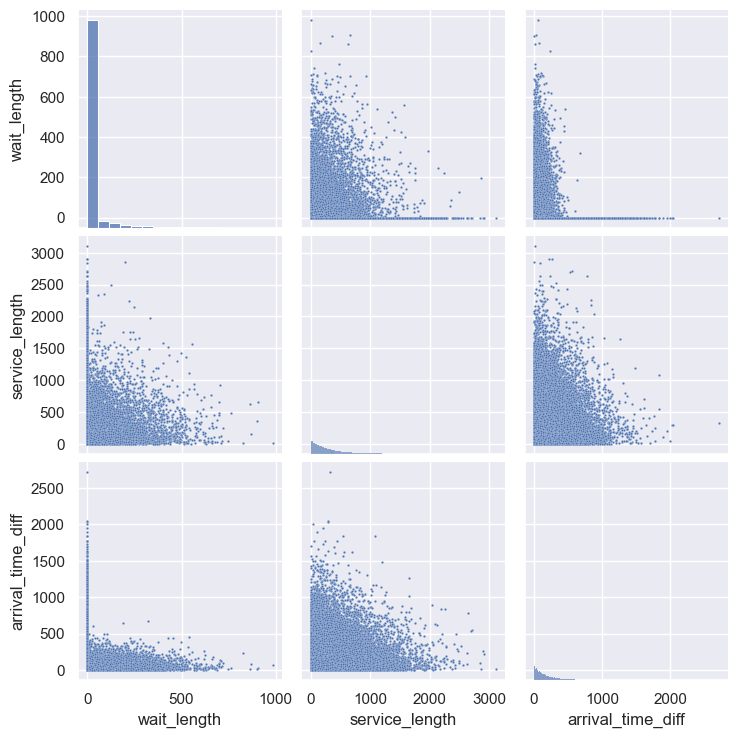

In [37]:
# Basic correlogram
sns.pairplot(data=df[["wait_length", "service_length", "arrival_time_diff"]], plot_kws={"s": 3})
plt.show()

### Análise por call types

É interessante analisar o comportamento de nossas variáveis aleatórias com relação ao tipo de ligação realizada. Há alguma diferença significativa entre os tipos 0, 1 e 2?

In [38]:
resumo_call_type(df, 0)

Ligações do tipo 0 atendidas em 2021: 12830
Ligações que demoraram mais de 60 segundos para atendimento: 1069
No ano de 2021, em média, 8.33% das ligações do tipo 0 demoraram mais de 60 segundos para serem atendidas


In [39]:
resumo_call_type(df, 1)

Ligações do tipo 1 atendidas em 2021: 25792
Ligações que demoraram mais de 60 segundos para atendimento: 2100
No ano de 2021, em média, 8.14% das ligações do tipo 1 demoraram mais de 60 segundos para serem atendidas


In [40]:
resumo_call_type(df, 2)

Ligações do tipo 2 atendidas em 2021: 13086
Ligações que demoraram mais de 60 segundos para atendimento: 1058
No ano de 2021, em média, 8.08% das ligações do tipo 2 demoraram mais de 60 segundos para serem atendidas


#### Teste não paramétrico para testar se os tempos de interesse são iguais para todos os tipos de ligação

In [41]:
testes = matrix_ks_2samp_test_types(random_var="service_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para duração de serviço")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.624788,0.441323
Call_type 1,0.624788,1.000000,0.771999
Call_type 2,0.441323,0.771999,1.000000


In [42]:
testes = matrix_ks_2samp_test_types(random_var="arrival_time_diff", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para intervalos de chegadas")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.985760,0.999016
Call_type 1,0.985760,1.000000,0.994172
Call_type 2,0.999016,0.994172,1.000000


In [43]:
testes = matrix_ks_2samp_test_types(random_var="wait_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempos de espera")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.968333,0.999602
Call_type 1,0.968333,1.000000,1.000000
Call_type 2,0.999602,1.000000,1.000000


Não há diferença estatística entre as distribuições dos tempos de chegada, de serviço e de espera de acordo com o tipo de ligação em base anual

## Análise mensal

### Tabela resumo das médias dos tempos de espera, serviço e de chegada de ligações mês a mês

In [44]:
data = {'mes': ["Janeiro", "Fevereiro", "Março", "Abril", "Maio",
                "Junho", "Julho", "Agosto", "Setembro",
                "Outubro", "Novembro", "Dezembro"],
        'mean_wait_length': [df.loc[df['date'].dt.month==n]["wait_length"].mean() for n in range(1, 13)],
        'mean_service_length': [df.loc[df['date'].dt.month==n]["service_length"].mean() for n in range(1, 13)],
        'mean_arrival_time_diff': [df.loc[df['date'].dt.month==n]["arrival_time_diff"].mean() for n in range(1, 13)],
        'mean_daily_calls': [df.loc[df['date'].dt.month==n].groupby(["date"])["daily_caller"].max().mean() for n in range (1,13)],
        '%_failure': [len(df.loc[df['date'].dt.month==n].loc[df["meets_standard"] == False]) /
                            len(df.loc[df['date'].dt.month==n]) * 100 for n in range(1, 13)]}

resumo = pd.DataFrame(data)
resumo.style.set_caption("Tabela de resumo das médias dos tempos de espera, serviço e de chegada de ligações mês a mês ")

,mes,mean_wait_length,mean_service_length,mean_arrival_time_diff,mean_daily_calls,%_failure
0,Janeiro,5.375000,295.091333,248.624000,143.047619,2.533333
1,Fevereiro,4.363280,307.153545,231.885332,153.300000,2.482849
2,Março,5.659839,293.362026,226.209798,157.347826,2.767783
3,Abril,4.787479,298.619989,214.172433,165.863636,2.828116
4,Maio,7.984802,301.791379,206.973750,173.190476,4.227687
5,Junho,9.218843,299.669242,195.431206,182.818182,4.985045
6,Julho,11.794931,298.707143,180.276498,197.772727,6.036866
7,Agosto,16.159325,304.865878,171.872452,208.090909,7.911462
8,Setembro,21.536639,296.592991,156.499403,229.090909,10.115492
9,Outubro,27.894146,302.287891,149.751203,238.047619,11.768244


A partir dessa tabela vemos que a média do tempo de espera aumenta mês a mês, a média do tempo de serviço permanece relativamente constante, o tempo entre chegadas diminui e, por isso, o número de ligações aumenta mês a mês.

Portanto, o percentual falhas, aqui definido como o percentual de chamadas que demoram mais de 60 segundos para serem atendidas, aumenta mês a mês, ultrapassando, a partir de setembro de 2021, a tolerância de 10% estipulada pelo gerente

## Análise trimestral

In [45]:
data = {'periodo': [f"Trimestre {n}" for n in range(1, 5)],
        'mean_wait_length': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                            ["wait_length"].mean() for t in range(0, 4)],
        'mean_service_length': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                               ["service_length"].mean() for t in range(0, 4)],
        'mean_arrival_time_diff': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                                  ["arrival_time_diff"].mean() for t in range(0, 4)],
        'mean_daily_calls': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)].groupby(["date"])
                            ["daily_caller"].max().mean() for t in range (0, 4)],
        '%_failure': [len(df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                          .loc[df["meets_standard"] == False]) /
                     len(df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]) 
                     * 100 for t in range(0, 4)]}

resumo2 = pd.DataFrame(data)
resumo2.style.set_caption("")

,periodo,mean_wait_length,mean_service_length,mean_arrival_time_diff,mean_daily_calls,%_failure
0,Trimestre 1,5.161257,298.262146,234.956481,151.390625,2.604920
1,Trimestre 2,7.391023,300.011532,205.191520,173.969231,4.045063
2,Trimestre 3,16.738384,299.962801,168.947504,211.651515,8.122083
3,Trimestre 4,30.560169,298.265443,139.674982,256.015152,14.183892


Uma agregação maior do que um mês, como a trimestral, subestima a porcentagem de falhas e pode esconder informações como a falha no mês de setembro, que está no 3º trimestre. Além disso, vimos que não é correto agregar o intervalo de chegadas em períodos maiores que um mês, já que este valor é alterado mensalmente

## Análise semanal

Testes de hipótese para verificar se há diferenças estatisticamente significativas do intervalo de chegada semana a semana

In [46]:
# Mês de janeiro intervalos de chegada
teste = matrix_ks_2samp_test_weeks(random_var="arrival_time_diff", df = df, semanas=[n for n in range(1, 9)])
teste.style.applymap(highlight_cells)

,1,2,3,4,5,6,7,8
1,1.000000,0.895541,0.635506,0.615615,0.497819,0.966903,0.588041,0.093597
2,0.895541,1.000000,0.823594,0.607070,0.351146,0.985249,0.443794,0.121901
3,0.635506,0.823594,1.000000,0.312581,0.381446,0.651136,0.470177,0.241507
4,0.615615,0.607070,0.312581,1.000000,0.057124,0.717159,0.115002,0.033184
5,0.497819,0.351146,0.381446,0.057124,1.000000,0.167075,0.958201,0.147202
6,0.966903,0.985249,0.651136,0.717159,0.167075,1.000000,0.548558,0.056267
7,0.588041,0.443794,0.470177,0.115002,0.958201,0.548558,1.000000,0.161125
8,0.093597,0.121901,0.241507,0.033184,0.147202,0.056267,0.161125,1.000000


In [47]:
# Mês de dezembro intervalos de chegada
teste = matrix_ks_2samp_test_weeks(random_var="arrival_time_diff", df = df, semanas=[n for n in range(45, 53)])
teste.style.applymap(highlight_cells)

,45,46,47,48,49,50,51,52
45,1.000000,0.182244,0.857725,0.320285,0.071961,0.166746,0.320232,0.180710
46,0.182244,1.000000,0.602844,0.125497,0.024914,0.181061,0.093705,0.080147
47,0.857725,0.602844,1.000000,0.139887,0.032820,0.140556,0.142464,0.104228
48,0.320285,0.125497,0.139887,1.000000,0.693380,0.949007,0.956980,0.933944
49,0.071961,0.024914,0.032820,0.693380,1.000000,0.696904,0.776036,0.735916
50,0.166746,0.181061,0.140556,0.949007,0.696904,1.000000,0.920658,0.793146
51,0.320232,0.093705,0.142464,0.956980,0.776036,0.920658,1.000000,0.661372
52,0.180710,0.080147,0.104228,0.933944,0.735916,0.793146,0.661372,1.000000


No horizonte de planejamento semanal, semanas subsequentes tendem a ter intervalos de chegada que seguem a mesma distribuição de probabilidade, e, portanto, o planejamento semanal não é interessante para esse problema, visto que não é possível perceber as diferenças de demanda nesse nível de análise

## Processo de modelagem dos intervalos entre chegadas (Regressão Linear e Expo)

In [48]:
# Valor esperado de tempo entre ligações por dia (média=lambda)
lam = df["arrival_time_diff"].mean()
print(f"A taxa de chegadas é, em média, de uma ligação a cada {lam :.2f}s")
print(f"Em base diária, teríamos a chegada, em média, de {10*60*60 / 179.67 :.0f} clientes por dia")

A taxa de chegadas é, em média, de uma ligação a cada 179.67s
Em base diária, teríamos a chegada, em média, de 200 clientes por dia


### Regressão linear da quantidade de chamados 

In [49]:
# Agrupando ligações por dia
ligacoes['dia'] = [i for i in range(1, 1 + len(df["date"].unique()))]
ligacoes.head()

,date,daily_caller,mes,dia
0,2021-01-01,146,1,1
1,2021-01-04,135,1,2
2,2021-01-05,143,1,3
3,2021-01-06,150,1,4
4,2021-01-07,133,1,5


In [129]:
# Input
x = ligacoes["dia"]
y = ligacoes["daily_caller"]
x = sm.add_constant(x)
# Regressão linear da quantidade de chamados
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
# print(print_model)

Temos que os valores p são menores que o nível de significância adotado, e, portanto, o modelo de regressão existe. A quantidade de chamados por dia aumenta ao longo do tempo seguindo a expressão:
$$n_{chamados}(t) = 0,5373 \cdot t + 128,3268$$
Em que $t$ é um dia útil trabalhado

### Regressão linear dos tempos de chegadas

In [51]:
chegadas = pd.DataFrame(chegadas)
chegadas['dia'] = [i for i in range(1, 1 + len(df["date"].unique()))]
chegadas.head()

,date,arrival_time_diff,mes,dia
0,2021-01-01,244.274,1,1
1,2021-01-04,264.741,1,2
2,2021-01-05,251.099,1,3
3,2021-01-06,238.033,1,4
4,2021-01-07,263.361,1,5


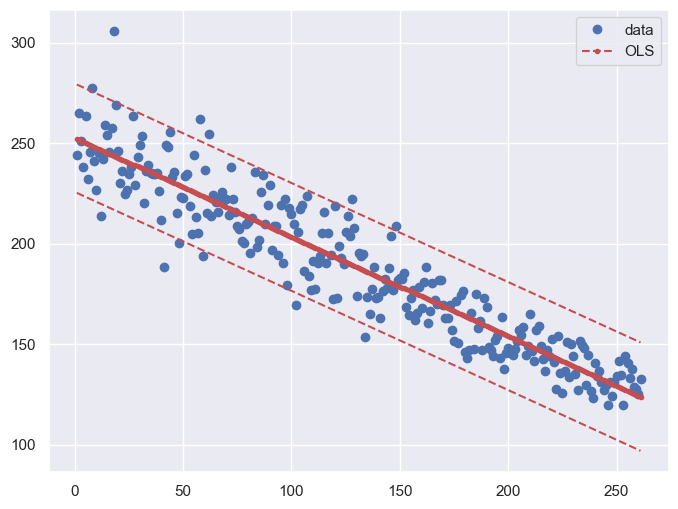

In [130]:
# Input
x = chegadas["dia"]
y = chegadas["arrival_time_diff"]
x = sm.add_constant(x)
# Regressão linear do tempo de chegadas
model       = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
# print(print_model)


#plotagem
pred_ols = model.get_prediction()
# print(pred_ols)
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x["dia"], y, "o", label="data")
ax.plot(x["dia"], model.fittedvalues, "r--.", label="OLS")
ax.plot(x["dia"], iv_u, "r--")
ax.plot(x["dia"], iv_l, "r--")
ax.legend(loc="best");

#fig.show();

In [53]:
# print(print_model)

Temos que os valores p são menores que o nível de significância adotado, e, portanto, o modelo de regressão existe. O intervalo entre chegadas depende do dia trabalhado seguindo a expressão:
$$intervalos(t) = -0,4933 \cdot t + 252,6629$$
Em que $t$ é um dia útil trabalhado.

Entretanto, para os dias em que $t > 512$ o tempo de chegada das chamadas seria negativo, o que levanta questões sobre se este método de regressão é aplicável para modelar o tempo entre as chamadas.

C:\Users\Lucas\Documents\Estudos\UFSCar\Simulacao\Projeto final\virtual-env\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


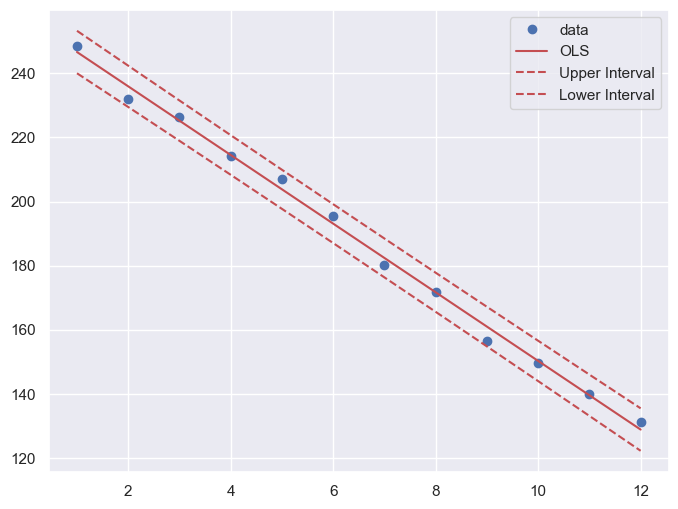

In [138]:
#regressão linear por mês: 
resumo.index = range(1,13)

x = resumo.index
y = resumo["mean_arrival_time_diff"]
x = sm.add_constant(x)
# Regressão linear do tempo de chegadas
model       = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
# print(print_model)

#plotagem
pred_ols = model.get_prediction()
print(pred_ols)
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x[:,1], y, "o", label="data")
ax.plot(x[:,1], model.fittedvalues, "r", label="OLS")
ax.plot(x[:,1], iv_u, "r--", label = "Upper Interval")
ax.plot(x[:,1], iv_l, "r--", label = "Lower Interval")

ax.legend(loc="best");
#fig.show()

In [136]:
# print(print_model)

In [56]:
# Input
ols_resid  = model.resid
 
resid_fit = sm.OLS(np.asarray(ols_resid)[1:], sm.add_constant(np.asarray(ols_resid)[:-1])).fit()
rho = resid_fit.params[1]
# Using toepliz matriz as of near neighbours have stronger correlation betweeen themselfs as for the rest
order = toeplitz(range(len(ols_resid))) #it should be as big as the resids from the OLS
sigma = rho ** order #assuring that the error strutcture is this, an autocorrelation

sigma = rho ** order

gls_model = sm.GLS(y, x, sigma=sigma)
gls_results = gls_model.fit()
# print(gls_results.summary())

# Não há plotagem para este método na lib

As diferenças entre os modelos de GLS e OLS foram ínfimas e podem ser feitas as mesmas considerações.

***

$$intervalos(t) = -0,4933 \cdot t + 252,6538$$


### Regressão exponencial dos tempos de chegada e número de ligações

C:\Users\Lucas\Documents\Estudos\UFSCar\Simulacao\Projeto final\virtual-env\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


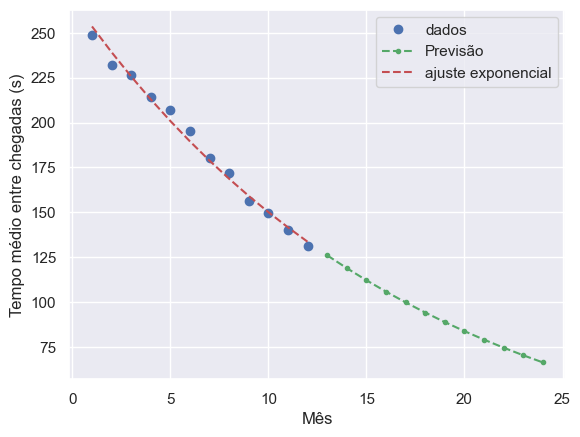

In [57]:
#regressão expo por mês: 
resumo.index = range(1,13)

x = resumo.index
y = resumo["mean_arrival_time_diff"]
x = sm.add_constant(x)
# Regressão linear do tempo de chegadas
model       = sm.OLS(np.log(y), x).fit()
predictions = model.predict(x)
print_model = model.summary()
# print(print_model)

# Crie um array com os valores de x para prever usando um list comprehension
x_pred = np.array([i for i in range(13, 25)])

# Faça as previsões de y em uma única linha de código
y_pred2 = np.exp(model.predict(sm.add_constant(x_pred)))

# Imprima as previsões


#plotagem
y_pred = np.exp(model.predict(x))
plt.plot(x[:,1], y, 'o', label='dados')
plt.plot(x_pred, np.array(y_pred2), "g--.", label="Previsão")
plt.plot(x[:,1], y_pred, "r--",label='ajuste exponencial')

plt.xlabel('Mês')

plt.ylabel('Tempo médio entre chegadas (s)')
plt.legend()
#plt.show()

#print(y_pred2)

In [58]:
#print(print_model)

C:\Users\Lucas\Documents\Estudos\UFSCar\Simulacao\Projeto final\virtual-env\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


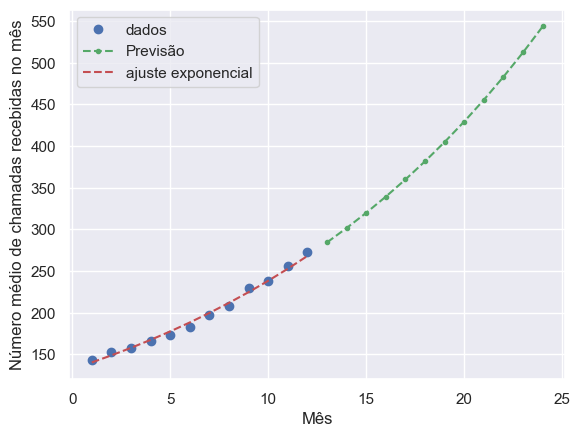

In [59]:
#regressão expo por mês: 
resumo.index = range(1,13)

x = resumo.index
y = resumo["mean_daily_calls"]
x = sm.add_constant(x)
# Regressão linear do tempo de chegadas
model       = sm.OLS(np.log(y), x).fit()
predictions = model.predict(x)
print_model = model.summary()
# print(print_model)

# Crie um array com os valores de x para prever usando um list comprehension
x_pred = np.array([i for i in range(13, 25)])

# Faça as previsões de y em uma única linha de código
y_pred2 = np.exp(model.predict(sm.add_constant(x_pred)))

# Imprima as previsões


#plotagem
y_pred = np.exp(model.predict(x))
plt.plot(x[:,1], y, 'o', label='dados')
plt.plot(x_pred, np.array(y_pred2), "g--.", label="Previsão")
plt.plot(x[:,1], y_pred, "r--",label='ajuste exponencial')

plt.xlabel('Mês')

plt.ylabel('Número médio de chamadas recebidas no mês')
plt.legend()
#plt.show()

#print(y_pred2)

In [60]:
#print(print_model)

## Fit dos intervalos entre chegadas para cada mês de 2021

In [61]:
def fit_mensal_arrival(mes):
    # DataFrame do mes
    data = df.loc[df["date"].dt.month==mes]
    # Fit
    arrival_times = data["arrival_time_diff"].values
    f = Fitter(arrival_times, distributions="expon")
    f.fit()
    print(f.summary())
    # Fit exponencial (melhor)
    print(f"\nParâmetros do fit exponencial: média = {f.fitted_param['expon'][1] :.4f}\n")

### Janeiro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.93it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     6.622e-07     2200.405 -66686.125    inf       0.014       0.595  

Parâmetros do fit exponencial: média = 248.6240



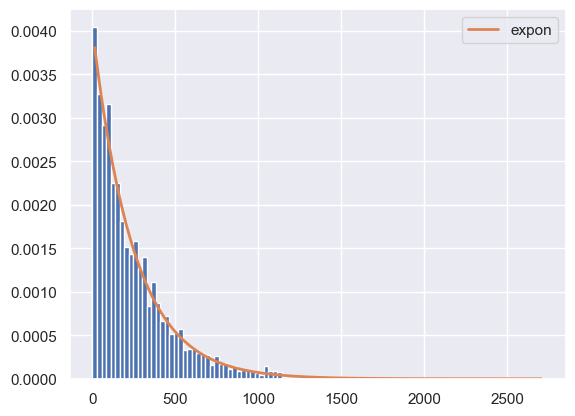

In [62]:
fit_mensal_arrival(1)

### Fevereiro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.98it/s]


       sumsquare_error     aic       bic    kl_div  ks_statistic  ks_pvalue
expon     1.003e-06     1970.406 -66832.55    inf       0.016       0.38   

Parâmetros do fit exponencial: média = 231.8853



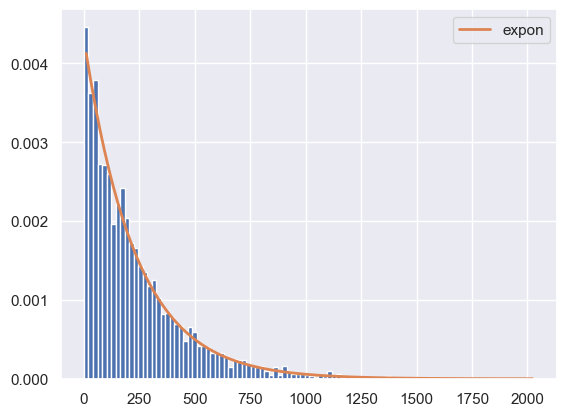

In [63]:
fit_mensal_arrival(2)

### Março

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.28it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     7.044e-07     1973.754 -80764.084    inf       0.014       0.443  

Parâmetros do fit exponencial: média = 226.2098



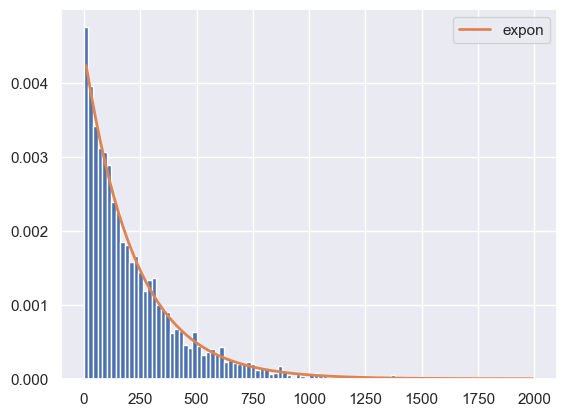

In [64]:
fit_mensal_arrival(3)

### Abril

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.65it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     1.233e-06     1904.727 -79403.603    inf       0.015       0.348  

Parâmetros do fit exponencial: média = 214.1724



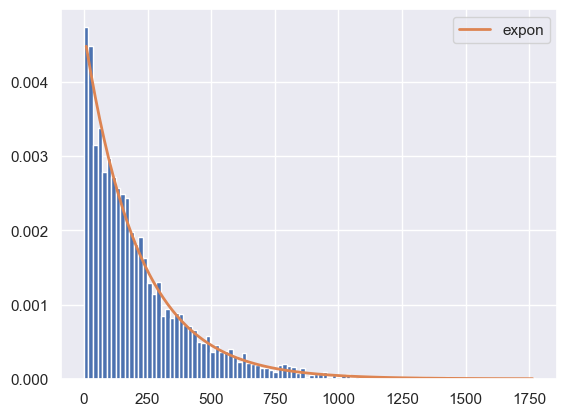

In [65]:
fit_mensal_arrival(4)

### Maio

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.07it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     1.117e-06     2058.566 -79236.038    inf       0.011       0.759  

Parâmetros do fit exponencial: média = 206.9737



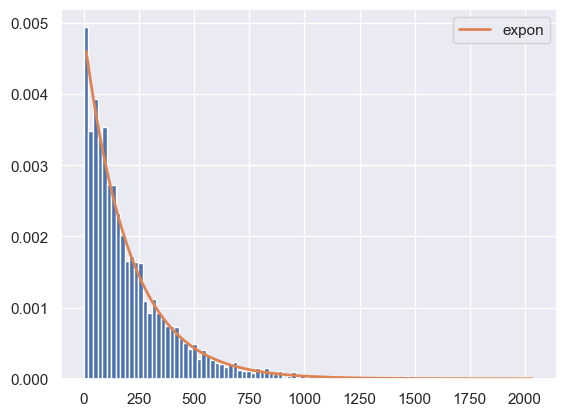

In [66]:
fit_mensal_arrival(5)

### Junho

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.64it/s]


       sumsquare_error    aic      bic    kl_div  ks_statistic  ks_pvalue
expon     1.303e-06     1858.3 -87638.36    inf       0.016       0.283  

Parâmetros do fit exponencial: média = 195.4312



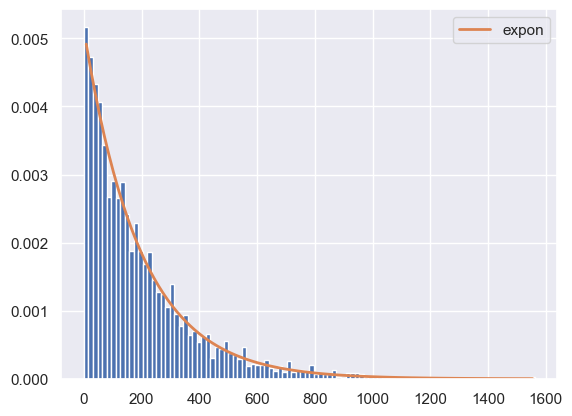

In [67]:
fit_mensal_arrival(6)

### Julho

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.87it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     1.034e-06     1883.829 -96145.929    inf       0.01        0.74   

Parâmetros do fit exponencial: média = 180.2765



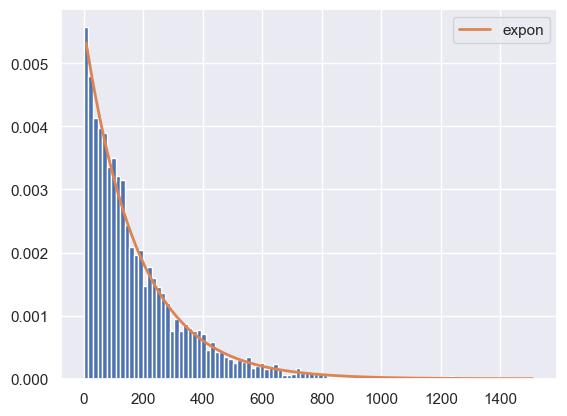

In [68]:
fit_mensal_arrival(7)

### Agosto

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


       sumsquare_error     aic       bic     kl_div  ks_statistic  ks_pvalue
expon     1.767e-06     1807.762 -98872.025    inf       0.013       0.377  

Parâmetros do fit exponencial: média = 171.8725



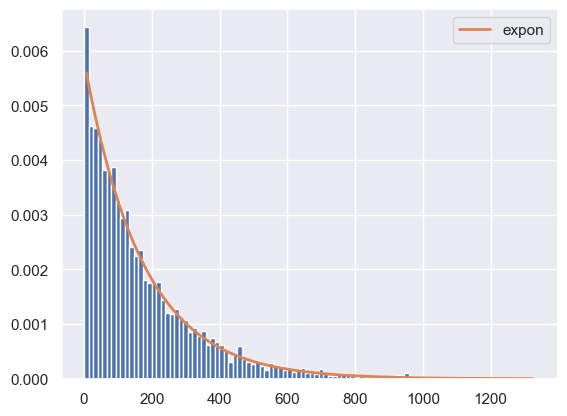

In [69]:
fit_mensal_arrival(8)

### Setembro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.97it/s]


       sumsquare_error    aic        bic     kl_div  ks_statistic  ks_pvalue
expon     1.060e-06     1779.47 -111866.533    inf       0.012       0.424  

Parâmetros do fit exponencial: média = 156.4994



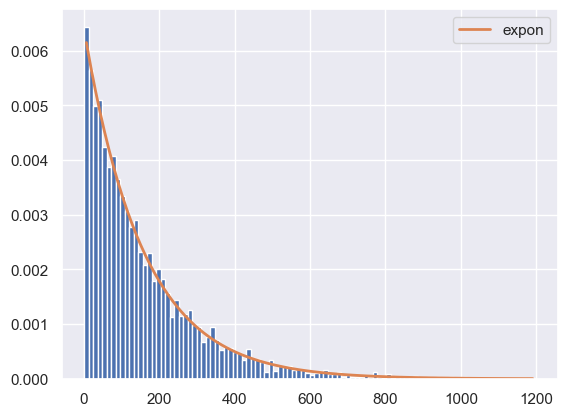

In [70]:
fit_mensal_arrival(9)

### Outubro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.31it/s]


       sumsquare_error     aic        bic     kl_div  ks_statistic  ks_pvalue
expon     5.998e-07     1871.898 -113915.996    inf       0.015       0.223  

Parâmetros do fit exponencial: média = 149.7512



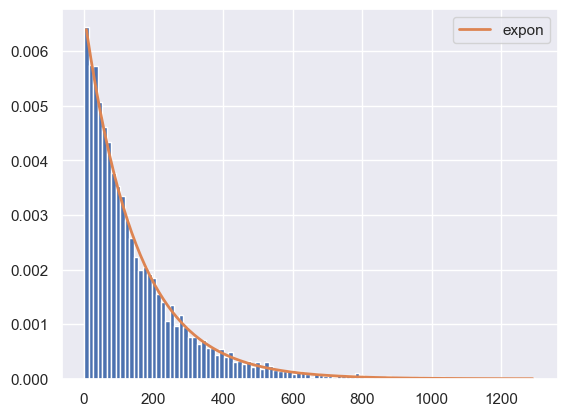

In [71]:
fit_mensal_arrival(10)

### Novembro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.48it/s]


       sumsquare_error     aic        bic     kl_div  ks_statistic  ks_pvalue
expon     2.282e-06     1835.352 -121037.234    inf       0.016       0.12   

Parâmetros do fit exponencial: média = 139.9637



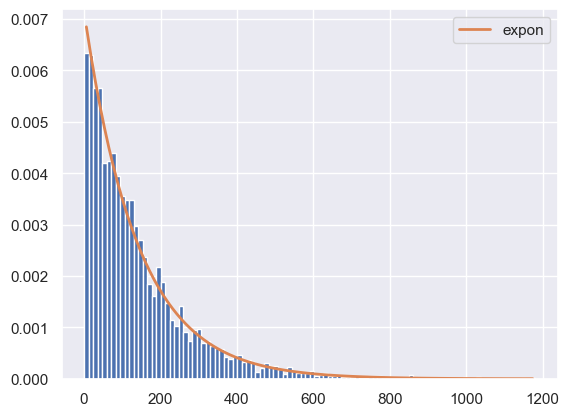

In [72]:
fit_mensal_arrival(11)

### Dezembro

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.88it/s]


       sumsquare_error     aic        bic     kl_div  ks_statistic  ks_pvalue
expon     1.078e-06     2002.647 -140464.994    inf       0.017       0.05   

Parâmetros do fit exponencial: média = 131.3733



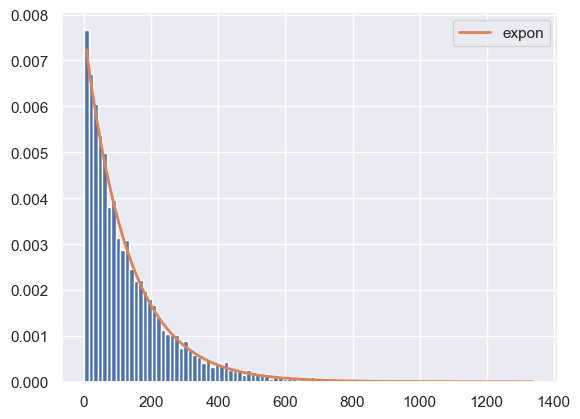

In [73]:
fit_mensal_arrival(12)

# Arena

## Modelo

![img](https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/Documentos/Entrega%203/simulacao/modelo-arena.png)

In [117]:
# Funções
def highlight_cells(val: float):
    '''Personalização do display dos dataframes de teste de hipóteses'''
    if val < 0.05:
        color = '#d14133'
    # elif val == 1:
    #     color = '#636363'
    elif val < 0.1:
        color = "#eeeb3d"
    elif val >= 0.1:
        color = '#399234'
    else:
        color = ''
    return 'background-color: {}'.format(color)


def arena_df_format(df):
    # Removendo coluna fantasma
    df = df.drop('Unnamed: 5', axis=1)

    # Ajustando os tipos das ligações
    df.loc[df["call_type"] == 2, "call_type"] = 0
    df.loc[df["call_type"] == 3, "call_type"] = 2

    # Tempos de serviço e de espera
    df["wait_length"] = df["call_answered"] - df["call_started"]
    df["service_length"] = df["call_ended"] - df["call_answered"]

    # Meets standard
    df["meets_standard"] = np.where(df["wait_length"] <= 60, True, False)

    # Ordenando o DataFrame de acordo com a ordem de chegada
    df = df.sort_values(by=["replication", "call_started"])
    df = df.reset_index(drop=True)

    # Coluna de ligação diária
    df['daily_caller'] = df.groupby('replication').cumcount() + 1

    # Define a data inicial e final
    start_date = datetime(2022, 1, 1) # O primeiro dia útil de 2021
    end_date = datetime(2022, 12, 31) # O último dia útil de 2021

    # Cria um DataFrame com um intervalo de datas úteis
    df_dates = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns=['date'])

    # Adiciona uma coluna com o número de dias úteis desde o início do ano
    df_dates['replication'] = df_dates.index + 1

    # Mescla com o DataFrame de datas
    df_merged = pd.merge(df, df_dates, on='replication')
    df = df_merged.copy()

    # Reordenando colunas
    df = df.reindex(columns=['replication', 'date', 'daily_caller', 'call_started', 
                            'call_answered', 'call_ended', 'wait_length', 
                            'service_length', 'meets_standard', 'call_type'])

    # Tempos entre chegadas
    df["arrival_time_diff"] = df["call_started"].diff()
    df.loc[df["arrival_time_diff"] < 0, "arrival_time_diff"] = 0
    df = df.fillna(0)

    # Retorna dataframe organizado
    return df

## Dados originais

In [118]:
# Leitura da base original
do = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/calls.csv")

# Conversão do time stamp da data
do["date"] = pd.to_datetime(do.date, format="%d/%m/%Y")
do["call_started"] = pd.to_datetime(do.call_started, format="%I:%M:%S %p")

# Cálculo dos tempos entre chegadas
do["arrival_time_diff"] = do["call_started"].diff().dt.total_seconds()

# Substitui os valores inadequados por 0
do.loc[do["arrival_time_diff"] < 0, "arrival_time_diff"] = 0
do = do.fillna(0)

# Apresentação
do.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type,arrival_time_diff
0,1,2021-01-01,1,1900-01-01 08:00:00,8:00:00 AM,8:14:22 AM,0,863,True,1,0.0
1,2,2021-01-01,2,1900-01-01 08:02:42,8:02:42 AM,8:07:31 AM,0,289,True,0,162.0
2,3,2021-01-01,3,1900-01-01 08:08:24,8:08:24 AM,8:10:13 AM,0,108,True,1,342.0
3,4,2021-01-01,4,1900-01-01 08:09:37,8:09:37 AM,8:13:45 AM,0,247,True,1,73.0
4,5,2021-01-01,5,1900-01-01 08:11:10,8:11:10 AM,8:15:28 AM,0,258,True,1,93.0


## Validação do modelo de simulação simplificado
É feita a análise para cada mês com 100 replicações

In [119]:
def dados_reais_mes(do, mes):
    # Dados reais deste mês
    df = do.loc[do["date"].dt.month==mes]
    
    # Quantidade de dias úteis no mês
    # a = len(df["date"].dt.day.unique())
    # print(f"Qtd. de dias úteis neste mês: {a}")
    return df


def teste_ks_validacao(da, do):
    # Validação do tempo de espera modelado
    stat, p1 = ks_2samp(da["wait_length"], do["wait_length"])
    # print(f"p-value do teste para tempos de espera: {p :.4f}")

    # Validação do tempo de serviço
    stat, p2 = ks_2samp(da["service_length"], do["service_length"])
    # print(f"p-value do teste para tempos de serviço: {p :.4f}")

    # Validação do tempo entre chegadas modelado
    stat, p3 = ks_2samp(da["arrival_time_diff"], do["arrival_time_diff"])
    # print(f"p-value do teste para tempos entre chegadas: {p :.4f}")
    return p1, p2, p3


def teste_validacao_modelo_simplificado(do):
    path = 'csv/validacao_modelo_simplificado.csv'
    header = ["wait_length", "service_length", "arrival_time_diff"]
    with open(path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for mes in range(1, 13):
            dh = do.copy()
            if mes == 1:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_janeiro_v2.csv")
            elif mes == 2:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_fevereiro_v2.csv")
            elif mes == 3:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_marco_v2.csv")
            elif mes == 4:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_abril_v2.csv")
            elif mes == 5:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_maio_v2.csv")
            elif mes == 6:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_junho_v2.csv")
            elif mes == 7:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_julho_v2.csv")
            elif mes == 8:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_agosto_v2.csv")
            elif mes == 9:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_setembro_v2.csv")
            elif mes == 10:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_outubro_v2.csv")
            elif mes == 11:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_novembro_v2.csv")
            elif mes == 12:
                da = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/files/output_dezembro_v2.csv")
            da = arena_df_format(da)
            d0 = dados_reais_mes(dh, mes)
            teste = teste_ks_validacao(da, d0)
            writer.writerow(teste)

### Validação do modelo de simulação mês a mês

In [120]:
teste_validacao_modelo_simplificado(do)
dff = pd.read_csv('csv/validacao_modelo_simplificado.csv')
dff = dff.rename(index=dict_meses)
dff.style.applymap(highlight_cells)

,wait_length,service_length,arrival_time_diff
0,1.000000,0.317516,0.310957
Janeiro,1.000000,0.313462,0.056111
Fevereiro,0.999991,0.594809,0.685034
Março,0.884678,0.172664,0.060925
Abril,1.000000,0.560986,0.308715
Maio,1.000000,0.493718,0.713599
Junho,1.000000,0.778257,0.579550
Julho,0.802289,0.697168,0.547951
Agosto,0.970986,0.867880,0.570443
Setembro,0.996798,0.285392,0.897156


## Modelo de simulação com tempo entre chegadas variando conforme regressão exponencial diária (todo o ano de 2021)

In [121]:
de = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/Modelo%20exponencial/output_call_center.csv")
de = arena_df_format(de)

In [122]:
# Coluna mês
conditions = [
    (de["replication"] <= 21),
    (de["replication"] > 21) & (de["replication"] <= 41),
    (de["replication"] > 41) & (de["replication"] <= 64),
    (de["replication"] > 64) & (de["replication"] <= 86),
    (de["replication"] > 86) & (de["replication"] <= 107),
    (de["replication"] > 107) & (de["replication"] <= 129),
    (de["replication"] > 129) & (de["replication"] <= 151),
    (de["replication"] > 151) & (de["replication"] <= 173),
    (de["replication"] > 173) & (de["replication"] <= 195),
    (de["replication"] > 195) & (de["replication"] <= 216),
    (de["replication"] > 216) & (de["replication"] <= 238),
    (de["replication"] > 238) & (de["replication"] <= 261)
]
values = [i for i in range(1, 13)]
de["mes"] = np.select(conditions, values)

In [123]:
def validacao_simulacao_expo_mes(de, do, mes):
    do = dados_reais_mes(do, mes)
    de = de.loc[de["mes"] == mes]
    teste = teste_ks_validacao(de, do)
    return teste


def teste_validacao_modelo_exponencial(do, de):
    path = 'csv/validacao_modelo_exponencial.csv'
    header = ["wait_length", "service_length", "arrival_time_diff"]
    with open(path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for mes in range(1, 13):
            dO = do.copy()
            dE = de.copy()
            teste = validacao_simulacao_expo_mes(dE, dO, mes)
            writer.writerow(teste)

### Validação do modelo de simulação mês a mês

In [124]:
teste_validacao_modelo_exponencial(do, de)
dff = pd.read_csv('csv/validacao_modelo_exponencial.csv')
dff = dff.rename(index=dict_meses)
dff.style.applymap(highlight_cells)

,wait_length,service_length,arrival_time_diff
0,1.000000,0.687544,0.970258
Janeiro,0.973854,0.514778,0.482204
Fevereiro,1.000000,0.161404,0.455566
Março,0.663732,0.118587,0.048333
Abril,0.757560,0.537213,0.414667
Maio,0.025933,0.678915,0.173306
Junho,1.000000,0.553623,0.594623
Julho,0.992315,0.433233,0.171680
Agosto,0.565452,0.832067,0.884495
Setembro,0.054283,0.065737,0.655950


## Modelo com tempo entre chegadas definidos com operadores lógicos

In [125]:
dl = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/arena/Modelo%20logico/output_call_center.csv")
dl = arena_df_format(dl)

In [126]:
# Coluna mês
conditions = [
    (dl["replication"] <= 21),
    (dl["replication"] > 21) & (dl["replication"] <= 41),
    (dl["replication"] > 41) & (dl["replication"] <= 64),
    (dl["replication"] > 64) & (dl["replication"] <= 86),
    (dl["replication"] > 86) & (dl["replication"] <= 107),
    (dl["replication"] > 107) & (dl["replication"] <= 129),
    (dl["replication"] > 129) & (dl["replication"] <= 151),
    (dl["replication"] > 151) & (dl["replication"] <= 173),
    (dl["replication"] > 173) & (dl["replication"] <= 195),
    (dl["replication"] > 195) & (dl["replication"] <= 216),
    (dl["replication"] > 216) & (dl["replication"] <= 238),
    (dl["replication"] > 238) & (dl["replication"] <= 261)]
values = [i for i in range(1, 13)]
dl["mes"] = np.select(conditions, values)

In [127]:
def validacao_simulacao_logico_mes(dl, do, mes):
    dO = do.copy()
    dL = dl.copy()
    dO = dados_reais_mes(dO, mes)
    dL = dL.loc[dL["mes"] == mes]
    teste = teste_ks_validacao(dL, dO)
    return teste


def teste_validacao_modelo_logico(do, dl):
    path = 'csv/validacao_modelo_logico.csv'
    header = ["wait_length", "service_length", "arrival_time_diff"]
    with open(path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for mes in range(1, 13):
            dO = do.copy()
            dL = dl.copy()
            teste = validacao_simulacao_logico_mes(dL, dO, mes)
            writer.writerow(teste)

### Validação do modelo de simulação mês a mês

In [128]:
teste_validacao_modelo_logico(do, dl)
dff = pd.read_csv('csv/validacao_modelo_logico.csv')
dff = dff.rename(index=dict_meses)
dff.style.applymap(highlight_cells)

,wait_length,service_length,arrival_time_diff
0,1.000000,0.599962,0.633926
Janeiro,0.999991,0.449836,0.069227
Fevereiro,1.000000,0.136573,0.581367
Março,0.722717,0.135395,0.059532
Abril,0.863854,0.612953,0.881812
Maio,0.218641,0.507515,0.885655
Junho,1.000000,0.639461,0.791167
Julho,0.999977,0.579174,0.291595
Agosto,0.273815,0.648022,0.578689
Setembro,0.050895,0.065970,0.643047


# Soluções propostas

## Contratação de atendentes
- Planos de contratação;
- Cenário com cumprimento total da meta;
- Cenário alternativo (econômico).

## Subcontratação

## Redução do tempo de atendimento

## Utilização de chatbots

## Classificação efetiva dos tipos de ligação recebidas

## Melhoria na comunicação com os clientes